# Figure for paper:
## Equivalent width of Helium versus Orbital Phase


Author: Michael Gully-Santiago  
Date: February 7, 2022

This notebook adapts previous notebooks made by Aishwarya Ganesh, see `08b_...` in the `01_exploratory/` notebook directory.

In [1]:
import numpy as np
import pandas as pd
import os
import glob
from astropy.io import fits
import warnings
import matplotlib.pyplot as plt
import astropy.units as u
from muler.hpf import HPFSpectrum
import seaborn as sns

from specutils.fitting import fit_continuum
from astropy.modeling import models

from astropy.time import Time
import lightkurve as lk
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper', font_scale=1.2)

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", message="Model is linear in parameters")

In [2]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

### Read in the table of metadata

In [3]:
#df = pd.read_csv('C:/Users/jojoa/GitHub/disperse/data/preliminary_results_He.csv')

In [4]:
df_raw = pd.read_csv('../../../blimp/data/tables/003_goldilocks_PSU_dropbox_1081x30_v1p0.csv')

In [5]:
target_mask = df_raw.OBJECT.str.contains('67') & ~df_raw.file_basename_Goldilocks.isna()
df = df_raw[target_mask]

## Assign the orbital phase

Let's compute the normalized phase shifted so that the transit midpoint always occurs at zero while also seeing the light curve before and after the midpoint.

$$\phi=\frac{\mod(t-T_c+\frac{P}{2}\;,P)}{P} -0.5$$ 

In [6]:
target_name = 'HAT-P-67b'
orbital_period = 4.81010250
t_c = 2455961.38467
t_c_btjd = t_c - 2457000.0 #neg value means discovered before TESS
t_14_hours = 6.989 # transit duration in hours
t_14_days = t_14_hours/24.0
t_14_orb_phase = t_14_days / orbital_period

In [7]:
df['JD'] = df['DATE-OBS'].apply(lambda x: Time(x).jd)
df['BTJD'] = df.JD -2457000.0

In [8]:
df['phase'] = np.mod(df.BTJD-t_c_btjd+(orbital_period*0.5),orbital_period)-0.5*orbital_period
df['normalized_phase']=(df['phase']/orbital_period)
df['in_transit_flag']=np.abs(df['normalized_phase']) < t_14_orb_phase/2.0

In [9]:
def get_full_path(fn, trimester, base_path=None):
    """Get the full path to the data synced from TACC
    
    Parameters:
    ----------
    
    fn (str): The Goldilocks or PSU reduced 1D filename
    trimester (str): The trimester identifier "QPROG" from the FITS header
    base_path: The root directory to the TACC-synced data
    """
    
    return str(base_path) + '/' + str(trimester) + '/' + str(fn)

In [10]:
base_path = '/Volumes/pecos/HPF/TACC'

In [11]:
df['full_path'] = df.apply(lambda x: get_full_path(x.file_basename_Goldilocks, x.QPROG, base_path=base_path), axis=1)

Assign the "campaigns" surrounding individual transits.

In [12]:
df['campaign'] = ''

df.campaign[df.night_of.isin(['2020-04-26', '2020-04-27', '2020-04-28'])] = 'April 2020'
df.campaign[df.night_of.str.contains('2020-05')] = 'May 2020'
df.campaign[df.night_of.str.contains('2020-06')] = 'June 2020'
df.campaign[df.campaign==''] = 'P4 (July 2020-March 2021)'

## Conduct Helium analysis

Derive median uncertainty

In [13]:
df = df.reset_index(drop=True)

In [16]:
threshold = 0.035 # SNR per pixel should be better than ~30:1

In [18]:
df['stddev_order19'] = 0.0
for i, fn in enumerate(df.full_path.values):
    spec_raw = HPFSpectrum(file=fn, order=19)
    spec = spec_raw.sky_subtract(method='vector').remove_nans().trim_edges().deblaze().normalize()
    spec = spec.apply_boolean_mask(spec.wavelength<(10827*u.Angstrom))
    df.loc[i, 'stddev_order19'] = np.nanstd(spec.flux.value)

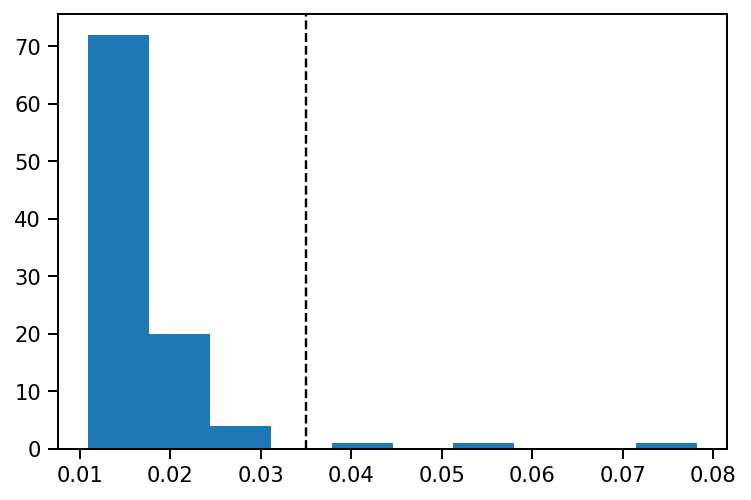

In [19]:
plt.hist(df.stddev_order19);
plt.axvline(threshold, linestyle='dashed', color='k')

In [20]:
high_snr = df.stddev_order19 < threshold

In [21]:
df = df[high_snr].reset_index(drop=True)

## Post-process the spectra
Apply the same method to each spectrum.  We will define some continuum indices to flatten to.

In [22]:
blue_limits = (10826.5*u.Angstrom, 10827.5*u.Angstrom)
red_limits = (10839.2*u.Angstrom, 10840.2*u.Angstrom)

window = [blue_limits, red_limits]

In [23]:
def flatten_to_regions(spec, windows, polynomial_order=None):
    """Flatten a spectrum to featureless continuum input regions
    
    Parameters:
    ----------
    spec (Spectrum1D-like):
        A spectrum to be flattened
    window (list of tuples):
        A list of pairs of boundaries at which the straight line will be computed
    polynomial_order (int):
        The polynomial order of the fit (defaults to 1-- straight line)
    """
    if polynomial_order is None:
        polynomial_order = 1
    linear_model = models.Chebyshev1D(polynomial_order)
    continuum_func = fit_continuum(spec, window=windows, model=linear_model)
    return spec/continuum_func(spec.wavelength)

In [24]:
spec_list = []
for fn in tqdm(df.full_path.values):
    spec_raw = HPFSpectrum(file=fn, order=19)
    spec =  spec_raw.sky_subtract(method='vector')\
                    .remove_nans()\
                    .trim_edges()\
                    .deblaze()\
                    .mask_tellurics(threshold=0.95, dilation=3)\
                    .barycentric_correct().normalize()
    spec = flatten_to_regions(spec, window)
    spec_list.append(spec)

  0%|          | 0/96 [00:00<?, ?it/s]

In [25]:
len(spec_list)

96

In [26]:
feature_indices = (10832.3, 10834.2)

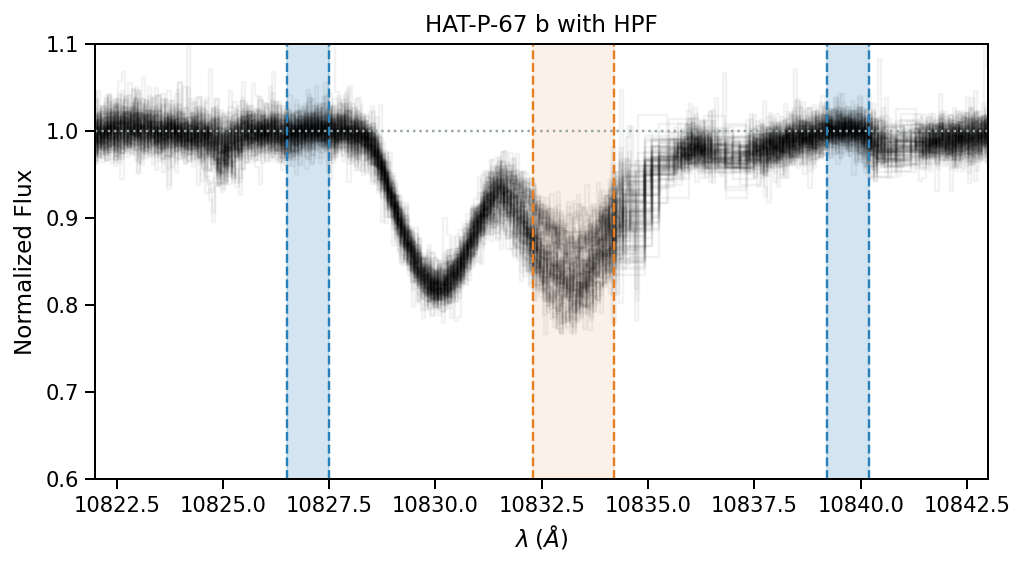

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))

for spec in spec_list:
    spec.plot(ax=ax, ylo=0, color='k', alpha=0.05)


ax.set_xlim(10822, 10843)
ax.axhline(1.0, linestyle='dotted', color='#95a5a6')

ax.axvline(blue_limits[0].value, linestyle='dashed', color='#2980b9')
ax.axvline(blue_limits[1].value, linestyle='dashed', color='#2980b9')
ax.fill_between([x.value for x in blue_limits], [2, 2], alpha=0.2, color='#2980b9')

ax.axvline(feature_indices[0], linestyle='dashed', color='#e67e22')
ax.axvline(feature_indices[1], linestyle='dashed', color='#e67e22')
ax.fill_between(feature_indices, [2, 2], alpha=0.1, color='#e67e22', zorder=0)

ax.axvline(red_limits[0].value, linestyle='dashed', color='#2980b9')
ax.axvline(red_limits[1].value, linestyle='dashed', color='#2980b9')
ax.fill_between([x.value for x in red_limits], [2, 2], alpha=0.2, color='#2980b9')

ax.set_xlabel('$\lambda\;(\AA)$')
ax.set_ylabel('Normalized Flux')
ax.set_title('HAT-P-67 b with HPF')

ax.set_ylim(0.6, 1.1)
plt.savefig('../../figures/HAT_P_67b_He_spectrum.jpg', bbox_inches='tight', dpi=300);

Neat, lets sort those by campaign

In [28]:
campaign = 'June 2020'

In [29]:
unique_nights = df[df.campaign==campaign].night_of.unique()
unique_nights

array(['2020-06-12', '2020-06-13', '2020-06-14', '2020-06-15',
       '2020-06-17'], dtype=object)

In [30]:
#pal = sns.color_palette("rocket", n_colors=len(unique_nights))
pal = sns.color_palette("cubehelix",n_colors=len(unique_nights))

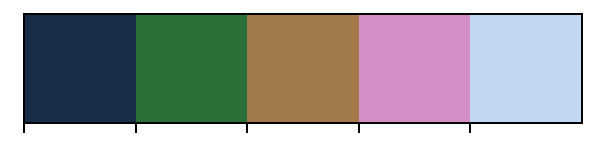

In [31]:
sns.palplot(pal)

In [32]:
color_dict = {night:pal[i] for i, night in enumerate(unique_nights)}

In [33]:
color_dict

{'2020-06-12': (0.09641540616370546, 0.17728671859553138, 0.28347363185399654),
 '2020-06-13': (0.17004232121057958, 0.43679759647517286, 0.22372555555555548),
 '2020-06-14': (0.6328422475018423, 0.4747981096220677, 0.29070209208025455),
 '2020-06-15': (0.8299576787894204, 0.5632024035248271, 0.7762744444444445),
 '2020-06-17': (0.7632674462838152, 0.850242277575182, 0.9515539762051686)}

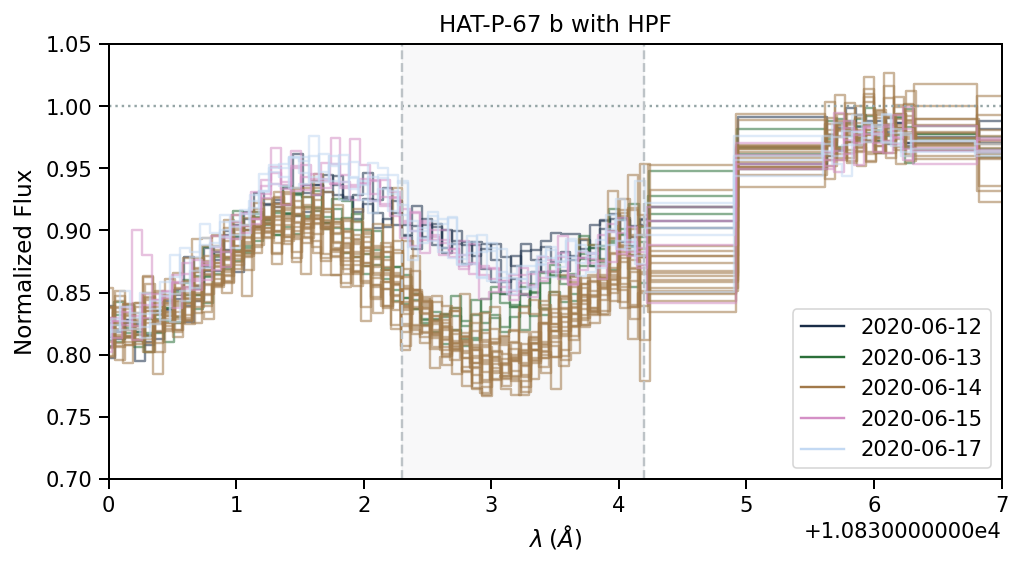

In [34]:
fig, ax = plt.subplots(figsize=(8, 4))

night_of = 'junk'
for i, spec in enumerate(spec_list):
    metadata = df.iloc[i]
    if metadata.campaign == campaign:
        color = color_dict[metadata.night_of]
        label = metadata.night_of if (night_of!=metadata.night_of) else None
        spec.plot(ax=ax, ylo=0, alpha=0.55, label=None, color=color)
        night_of = metadata.night_of


# Hack to get the labels to be bold.
night_of = 'junk'
for i, spec in enumerate(spec_list):
    metadata = df.iloc[i]
    if metadata.campaign == campaign:
        color = color_dict[metadata.night_of]
        label = metadata.night_of if (night_of!=metadata.night_of) else None
        (spec*-1).plot(ax=ax, ylo=0, alpha=1, label=label, color=color)
        night_of = metadata.night_of
        
        
plt.legend(loc='best')
ax.set_xlim(10830, 10837)
ax.axhline(1.0, linestyle='dotted', color='#95a5a6')

ax.axvline(blue_limits[0].value, linestyle='dashed', color='#2980b9')
ax.axvline(blue_limits[1].value, linestyle='dashed', color='#2980b9')
ax.fill_between([x.value for x in blue_limits], [2, 2], alpha=0.2, color='#2980b9')

ax.axvline(feature_indices[0], linestyle='dashed', color='#bdc3c7')
ax.axvline(feature_indices[1], linestyle='dashed', color='#bdc3c7')
ax.fill_between(feature_indices, [2, 2], alpha=0.1, color='#bdc3c7', zorder=0)

ax.axvline(red_limits[0].value, linestyle='dashed', color='#2980b9')
ax.axvline(red_limits[1].value, linestyle='dashed', color='#2980b9')
ax.fill_between([x.value for x in red_limits], [2, 2], alpha=0.2, color='#2980b9')

ax.set_xlabel('$\lambda\;(\AA)$')
ax.set_ylabel('Normalized Flux')
ax.set_title('HAT-P-67 b with HPF')

ax.set_ylim(0.7, 1.05)
fn_out = '../../figures/HAT_P_67b_He_{}.jpg'.format(campaign)
fn_out = fn_out.replace(' ', '').replace('(', '').replace(')', '')
plt.savefig(fn_out, bbox_inches='tight', dpi=300);

Neat!  Let's make a transmission spectrum plot.

In [35]:
from muler.utilities import combine_spectra_misaligned

In [36]:
night1_spectra = [spec for i, spec in enumerate(spec_list) if df.iloc[i].night_of == '2020-06-12']
night2_spectra = [spec for i, spec in enumerate(spec_list) if df.iloc[i].night_of == '2020-06-13']
night3_spectra = [spec for i, spec in enumerate(spec_list) if df.iloc[i].night_of == '2020-06-14']
night4_spectra = [spec for i, spec in enumerate(spec_list) if df.iloc[i].night_of == '2020-06-15']
night5_spectra = [spec for i, spec in enumerate(spec_list) if df.iloc[i].night_of == '2020-06-17']

In [37]:
pixel_midpoints = spec_raw.wavelength.value

In [38]:
night1 = combine_spectra_misaligned(night1_spectra, pixel_midpoints=pixel_midpoints)
night2 = combine_spectra_misaligned(night2_spectra, pixel_midpoints=pixel_midpoints)
night3 = combine_spectra_misaligned(night3_spectra, pixel_midpoints=pixel_midpoints)
night4 = combine_spectra_misaligned(night4_spectra, pixel_midpoints=pixel_midpoints)
night5 = combine_spectra_misaligned(night5_spectra, pixel_midpoints=pixel_midpoints)

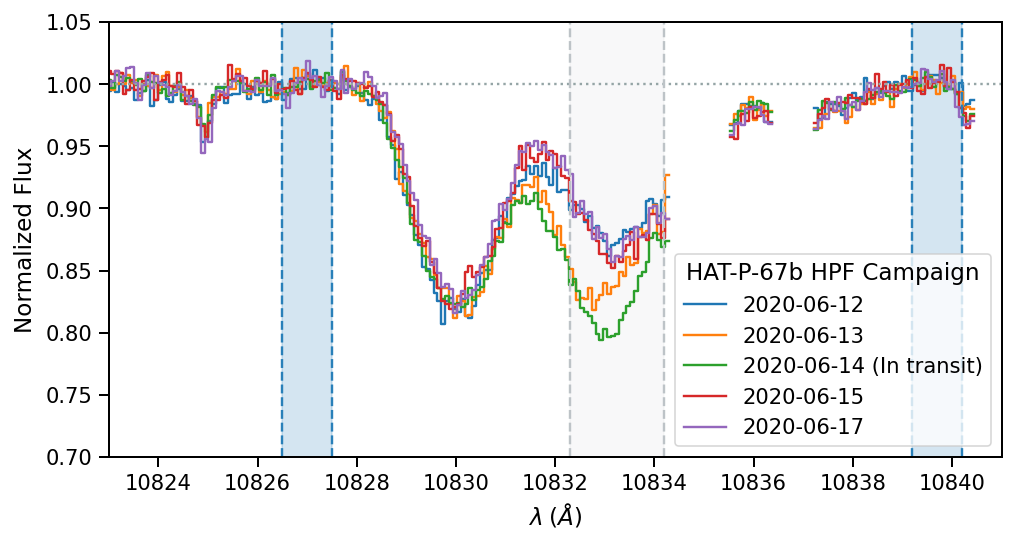

In [39]:
fig, ax = plt.subplots(figsize=(8, 4))
night1.plot(ax=ax, label='2020-06-12')
night2.plot(ax=ax, label='2020-06-13')
night3.plot(ax=ax, label='2020-06-14 (In transit)')
night4.plot(ax=ax, label='2020-06-15')
night5.plot(ax=ax, label='2020-06-17')


ax.set_xlim(10823, 10841)
ax.axhline(1.0, linestyle='dotted', color='#95a5a6')

ax.axvline(blue_limits[0].value, linestyle='dashed', color='#2980b9')
ax.axvline(blue_limits[1].value, linestyle='dashed', color='#2980b9')
ax.fill_between([x.value for x in blue_limits], [2, 2], alpha=0.2, color='#2980b9')

ax.axvline(feature_indices[0], linestyle='dashed', color='#bdc3c7')
ax.axvline(feature_indices[1], linestyle='dashed', color='#bdc3c7')
ax.fill_between(feature_indices, [2, 2], alpha=0.1, color='#bdc3c7', zorder=0)

ax.axvline(red_limits[0].value, linestyle='dashed', color='#2980b9')
ax.axvline(red_limits[1].value, linestyle='dashed', color='#2980b9')
ax.fill_between([x.value for x in red_limits], [2, 2], alpha=0.2, color='#2980b9')

ax.set_xlabel('$\lambda\;(\AA)$')
ax.set_ylabel('Normalized Flux')
ax.legend(title='HAT-P-67b HPF Campaign')

ax.set_ylim(0.7, 1.05)
plt.savefig('../../figures/HAT-P-67_June2020_clean.png', bbox_inches='tight', dpi=300)

Neat!  There is velocity structure there!

### Make a transmission spectrum in the planet rest frame

Can we shift the spectrum into the planet rest-frame?  Divide the circumference by the period to get instantaneous tangential velocity.  Assume a circular orbit:

$$ v = \frac{2 \pi a}{P}$$

In [40]:
semi_major_axis = 0.06505 * u.AU

In [41]:
planet_speed_quantity = (2*np.pi*semi_major_axis)/(orbital_period*u.day)

In [42]:
planet_speed_quantity.to(u.km/u.second)

<Quantity 147.1243333 km / s>

In [43]:
planet_speed = planet_speed_quantity.to(u.km/u.second).value

Convention: Positive RVs are redshifted

In [44]:
df['RV_planet'] = planet_speed * np.sin(df.normalized_phase)

In [45]:
df.groupby(['night_of', 'in_transit_flag']).RV_planet.mean().to_frame()

,,RV_planet
night_of,in_transit_flag,
2020-04-26,False,-28.038899
2020-04-27,True,2.677058
2020-04-28,False,32.787522
2020-05-19,False,-53.678161
2020-05-20,False,-24.676725
2020-05-21,True,-0.867923
2020-05-22,False,35.863565
2020-05-23,False,64.660793
2020-06-12,False,-56.928633


### Let's make a transmission spectrum:

We'll simply use night 5 as the out-of-transit spectrum reference.

$$T(\lambda) = \frac{f_{out}-f_{in}}{f_{out}}$$



In [46]:
rp_over_rstar = 0.0834
transit_depth = rp_over_rstar**2
transit_depth

0.00695556

In [47]:
out_of_transit = night5

trans_3 = (out_of_transit.subtract(night3)).divide(out_of_transit)
trans_3 = trans_3.add(transit_depth*u.dimensionless_unscaled).multiply(100.0*u.dimensionless_unscaled)
trans_3 = trans_3.rv_shift(1.033626)

trans_2 = (out_of_transit.subtract(night2)).divide(out_of_transit)
trans_2 = trans_2.add(transit_depth*u.dimensionless_unscaled).multiply(100.0*u.dimensionless_unscaled)
trans_2 = trans_2.rv_shift(-27.756549)

trans_1 = (out_of_transit.subtract(night1)).divide(out_of_transit)
trans_1 = trans_1.add(transit_depth*u.dimensionless_unscaled).multiply(100.0*u.dimensionless_unscaled)
trans_1 = trans_1.rv_shift(-56.928633)

trans_4 = (out_of_transit.subtract(night4)).divide(out_of_transit)
trans_4 = trans_4.add(transit_depth*u.dimensionless_unscaled).multiply(100.0*u.dimensionless_unscaled)
trans_4 = trans_4.rv_shift(32.614198)

Convert to velocity space:

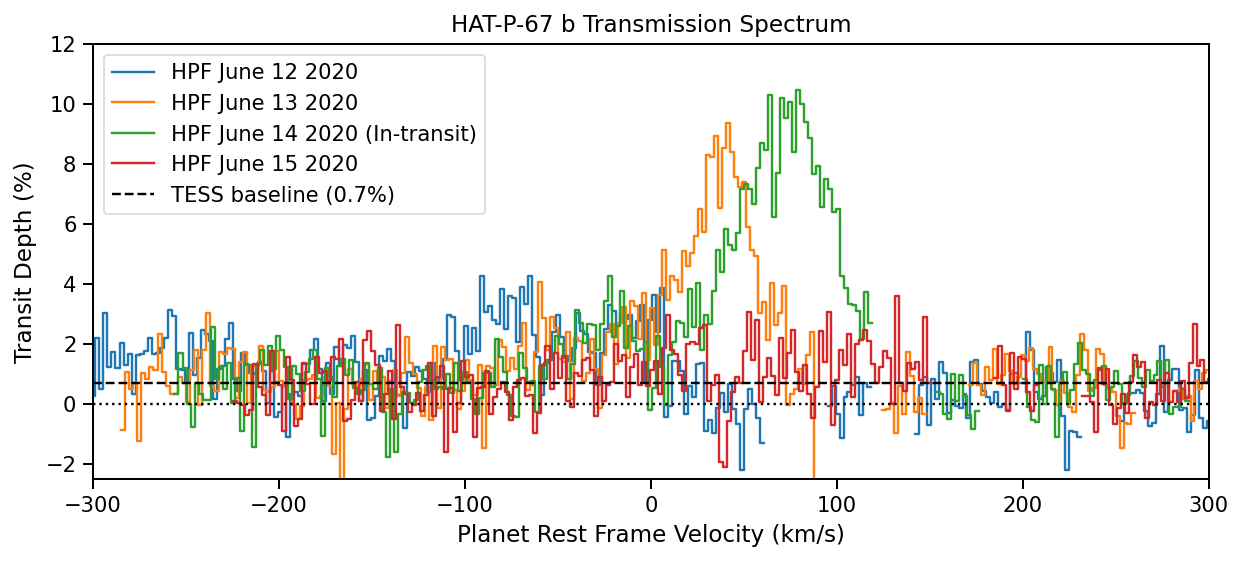

In [48]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.step(300_000*(trans_1.wavelength.value-10830)/10830, trans_1.flux.value, label='HPF June 12 2020')
ax.step(300_000*(trans_2.wavelength.value-10830)/10830, trans_2.flux.value, label='HPF June 13 2020')
ax.step(300_000*(trans_3.wavelength.value-10830)/10830, trans_3.flux.value, label='HPF June 14 2020 (In-transit)')
ax.step(300_000*(trans_4.wavelength.value-10830)/10830, trans_4.flux.value, label='HPF June 15 2020')
#ax.step(label='HPF June 13 2020', ax=ax)
#ax.step(label='HPF June 14 2020 (In-transit)', ax=ax)
#ax.step(label='HPF June 15 2020', ax=ax, alpha=0.2)



ax.axhline(0.0, color='k', linestyle='dotted')
ax.axhline(transit_depth*100, color='k', linestyle='dashed', label='TESS baseline (0.7%)')

ax.set_xlim(-300, 300)
ax.set_ylabel('Transit Depth (%)')
ax.set_xlabel('Planet Rest Frame Velocity (km/s)')
ax.legend()
ax.set_title('HAT-P-67 b Transmission Spectrum')
plt.ylim(-2.5, 12);

plt.savefig('../../figures/HAT_P_67b_transmission_June2020.png', bbox_inches='tight', dpi=300)

Awesome, that figure looks great!

Let's save one of those spectra as a demo to input into `p-winds`:

<AxesSubplot:title={'center':'HPF Spectrum'}, xlabel='$\\lambda \\;(\\AA)$', ylabel='Flux'>

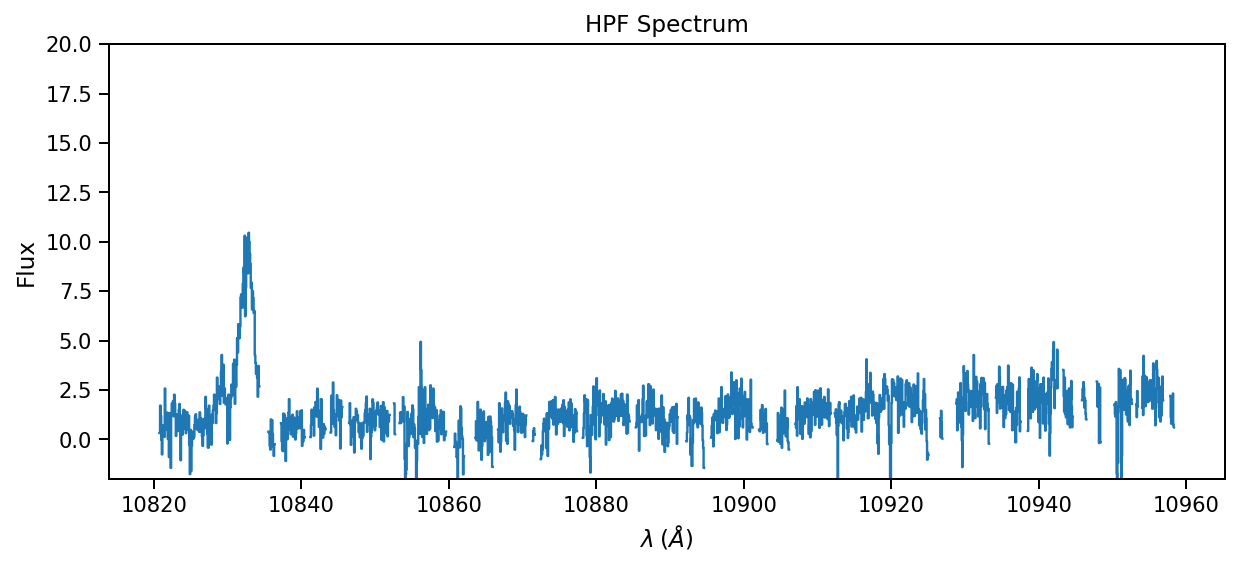

In [53]:
trans_3.plot(ylo=-2, yhi=20)


In [56]:
trans_3 = trans_3.remove_nans()

In [63]:
df_out.flux.std()

1.3791121019114834

In [67]:
df_out = pd.DataFrame({'wl':trans_3.wavelength.value, 'flux':trans_3.flux.value})

In [68]:
df_out.to_csv('../../data/HPF/HPF_HAT_P_67_20200614_exosphere.csv', index=False)

In [ ]:
! ../

In [37]:
df.groupby(['night_of', 'in_transit_flag']).normalized_phase.mean().to_frame()

,,normalized_phase
night_of,in_transit_flag,
2020-04-26,False,-0.191753
2020-04-27,True,0.018197
2020-04-28,False,0.224743
2020-05-19,False,-0.373471
2020-05-20,False,-0.168524
2020-05-21,True,-0.005899
2020-05-22,False,0.246245
2020-05-23,False,0.455040
2020-06-12,False,-0.397313


Ok, neat, we can see where the Telluric absorption resides, we have masked it for now.

## Compute Equivalent Width

In [38]:
ews = []
for i, spec in tqdm(enumerate(spec_list), total=len(spec_list)):
    ew = spec.measure_ew(lower=feature_indices[0], upper=feature_indices[1])
    ews.append(ew)

  0%|          | 0/96 [00:00<?, ?it/s]

In [39]:
df['ew'] = [ew.value for ew in ews]

## Plot the EW versus time and orbital phase

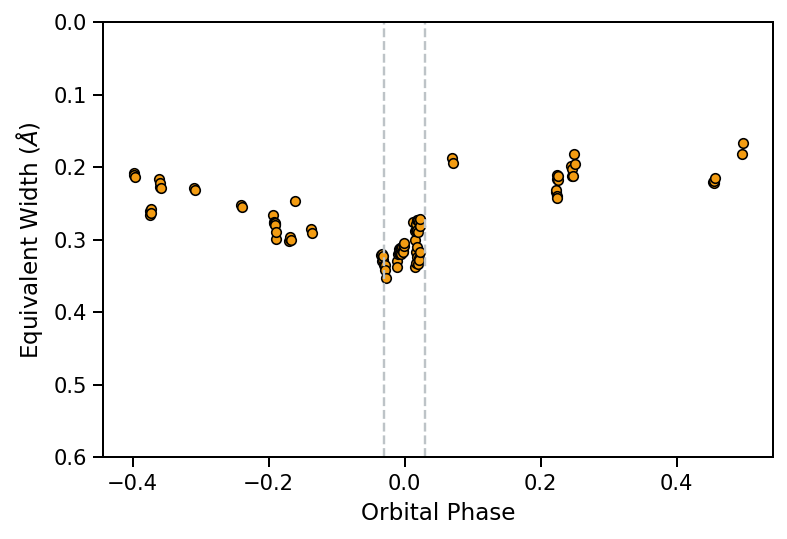

In [40]:
plt.scatter(df.normalized_phase, df.ew, ec='k', color='#f39c12')

plt.ylim(0.6, 0)
plt.axvline(-t_14_orb_phase/2, linestyle='dashed', color='#bdc3c7')
plt.axvline(+t_14_orb_phase/2, linestyle='dashed', color='#bdc3c7')
plt.xlabel('Orbital Phase');
plt.ylabel('Equivalent Width $(\AA)$');

Neat! We see an apparent asymmetric-in-orbital-phase absorption profile.

## Group the individual exposures into visits

In [41]:
gb = df.groupby(['night_of', 'in_transit_flag'])

In [42]:
mean_cols = gb.aggregate({'ew':np.mean, 'BTJD':np.mean, 'normalized_phase':np.mean, 
                          'campaign':lambda x:np.unique(x)[0]})

In [43]:
std_cols = gb.aggregate({'ew':np.std, 'BTJD':lambda x: np.ptp(x)/2, 
                         'normalized_phase':lambda x: np.ptp(x)/2, 'night_number':len})\
            .rename(columns={'ew':'ew_unc', 
                             'BTJD':'BTJD_range', 
                             'normalized_phase':'phase_range',
                             'night_number':'N_exposures'})

In [44]:
df_agg = pd.concat([mean_cols, std_cols], axis=1).sort_values('BTJD').reset_index()

Place a minimum EW uncertainty:

In [45]:
systematic_noise_floor = 0.003

In [46]:
df_agg.ew_unc[df_agg.ew_unc.isna()| (df_agg.ew_unc<systematic_noise_floor)] = systematic_noise_floor

In [71]:
def repeat_plot(df_agg, color, label):
    """Repeat the plot elements"""
    plt.scatter(df_agg.normalized_phase, df_agg.ew, ec='k', color=color, s=75, label=label)
    plt.errorbar(df_agg.normalized_phase, df_agg.ew, yerr=df_agg.ew_unc, xerr=df_agg.phase_range,linestyle='none', color='k', 
             barsabove=True, capsize=2, zorder=0)

In [72]:
campaigns = ['April 2020', 'May 2020', 'June 2020', 'P4 (July 2020-March 2021)']
colors = ['#f39c12', '#27ae60', '#3498db', '#8e44ad']

In [73]:
sns.set_context('talk', font_scale=1.0)

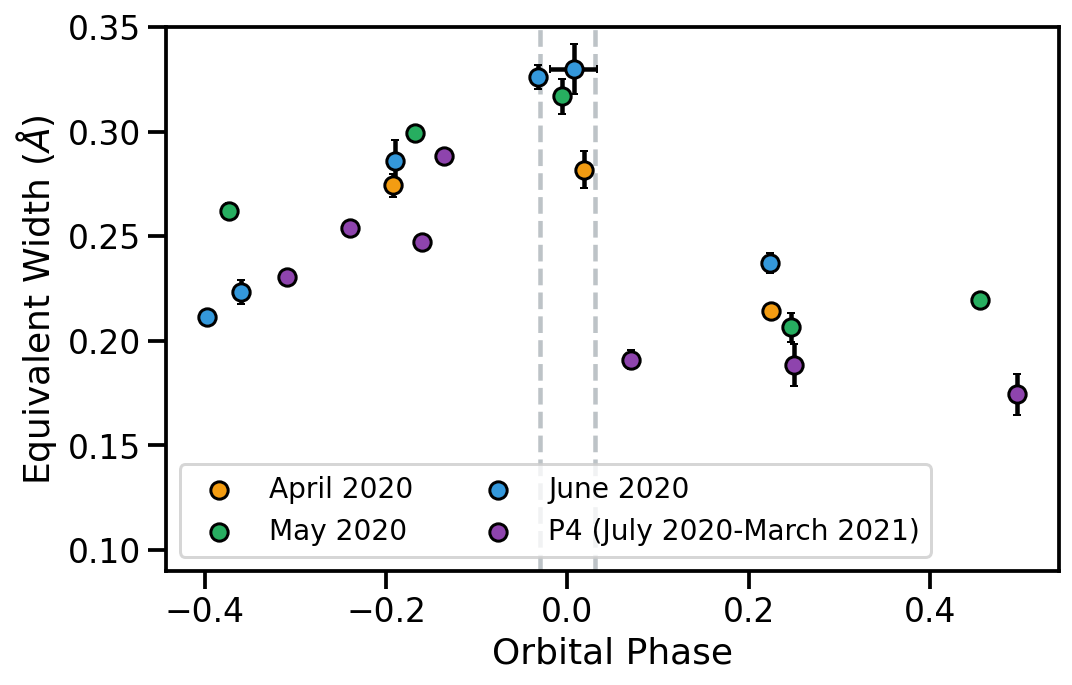

In [78]:
plt.figure(figsize=(8,5))

for label, color in zip(campaigns, colors):
    repeat_plot(df_agg[df_agg.campaign==label], color, label)

plt.ylim(0.09, 0.35)
plt.axvline(-t_14_orb_phase/2, linestyle='dashed', color='#bdc3c7', zorder=-1)
plt.axvline(+t_14_orb_phase/2, linestyle='dashed', color='#bdc3c7', zorder=-1)
plt.xlabel('Orbital Phase');
plt.ylabel('Equivalent Width $(\AA)$')
plt.legend(loc='lower left', ncol=2, fontsize=14)
plt.savefig('../../figures/HAT_P_67b_Helium10830EW_byCampaign.jpg', bbox_inches='tight', dpi=300, );

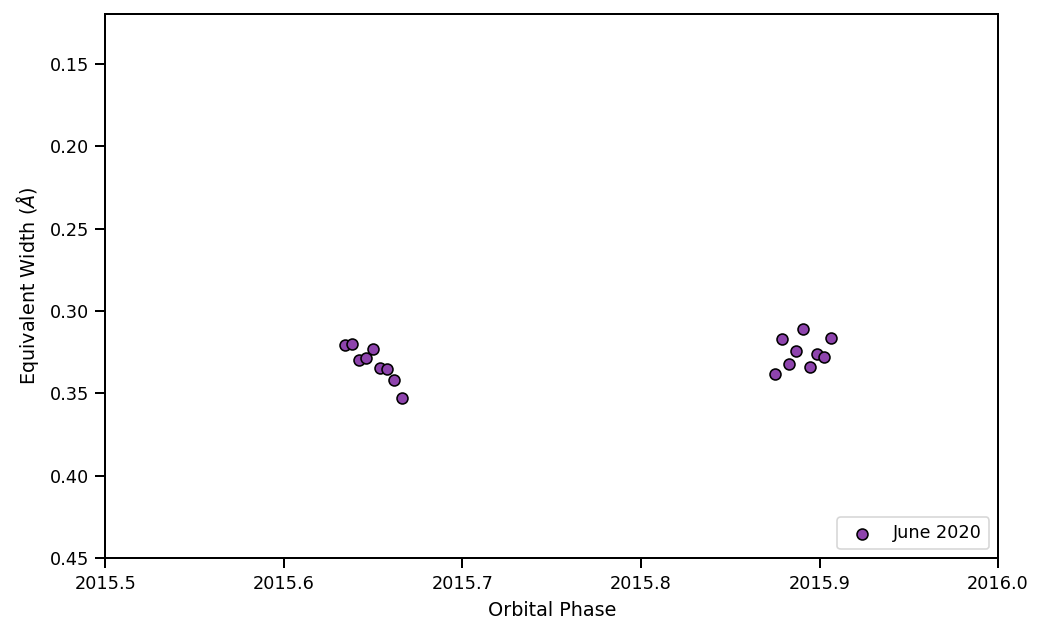

In [61]:
plt.figure(figsize=(8,5))

label = 'June 2020'
mask = df.campaign == label
plt.scatter(df.BTJD[mask], df.ew[mask], ec='k', color=color, s=30, label=label)



plt.legend(loc='lower right')
plt.ylim(0.45, 0.12)
plt.xlim(2015.5, 2016.0)
#plt.axvline(-t_14_orb_phase/2, linestyle='dashed', color='#bdc3c7', zorder=-1)
#plt.axvline(+t_14_orb_phase/2, linestyle='dashed', color='#bdc3c7', zorder=-1)
plt.xlabel('Orbital Phase');
plt.ylabel('Equivalent Width $(\AA)$')
plt.title('');

Neat! 

## Plot the line profile

In [ ]:
df['ew']=df.ew.astype(np.float).values #change str to float
df['btjd']=df['jd']-2457000.0 #cut down JD to smaller scale

In [ ]:
sn_ratio=2
good_data_mask=(df.ew/df.ew_unc)>sn_ratio #signal to noise ratio

In [ ]:
df=df[good_data_mask]

In [ ]:
x_line=df['ew'].median() #calculate horizontal line going between in/out of transit points
x_line

In [ ]:
plt.figure(figsize=(25,6))
#plt.errorbar(df.btjd, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.btjd, df.ew, 'bo', markersize=10)
plt.xlabel('Barycentric TESS Julian Date', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15)

In [ ]:
plt.figure(figsize=(25,6))
#plt.errorbar(df.btjd, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.btjd, df.ew, 'bo', markersize=5)
plt.plot(df.btjd[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=5) #change index to jd for time
#plt.ylim(0)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name}', fontsize=20)
plt.xlabel('Barycentric TESS Julian Date', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15)
#plt.savefig(f'../figures/{target_name}.jpg')

In [ ]:
df['phase']=np.mod(df.btjd-t_c_btjd+(orbital_period*0.5),orbital_period)-0.5*orbital_period
df['normalized_phase']=(df['phase']/orbital_period)

In [ ]:
df.describe() #max less than orbital period, normalized less than 1

In [ ]:
plt.figure(figsize=(25,6))

plt.errorbar(df.normalized_phase, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.normalized_phase[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

#plt.errorbar(df.normalized_phase-1, df.ew, yerr=df.ew_unc, fmt='b.')
#plt.plot(df.normalized_phase[in_transit_mask]-1, df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

#plt.errorbar(df.normalized_phase+1, df.ew, yerr=df.ew_unc, fmt='b.')
#plt.plot(df.normalized_phase[in_transit_mask]+1, df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

#plt.ylim(0.9,1.32)
plt.xlim(-.5,.5)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name}', fontsize=20)
plt.xlabel('Normalized Orbital Phase', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15)
#plt.savefig(f'../figures/{target_name}.jpg')

In [ ]:
plt.figure(figsize=(25,6))

plt.plot(df.phase, df.ew, 'bo', markersize=10)
plt.plot(df.phase[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

#plt.plot(df.normalized_phase-1, df.ew, 'bo', markersize=10)
#plt.plot(df.normalized_phase[in_transit_mask]-1, df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

#plt.plot(df.normalized_phase+1, df.ew, 'bo', markersize=10)
#plt.plot(df.normalized_phase[in_transit_mask]+1, df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

#plt.ylim(0.9,1.32)
#plt.xlim(-2,2)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name}', fontsize=20)
plt.xlabel('Normalized Orbital Phase', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15)
plt.savefig(f'../figures/{target_name}.jpg')

Let's define a variable called 'shifted' in two steps.

In [ ]:
second_half_mask = df.normalized_phase > 0.5
first_half_mask = ~second_half_mask

In [ ]:
df['shifted']=df.normalized_phase
df.shifted[second_half_mask]=df.shifted[second_half_mask]-1
df.shifted[second_half_mask]

In [ ]:
plt.figure(figsize=(25,6))
plt.errorbar(df.shifted, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.shifted[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time
#plt.ylim(0.9,1.32)
plt.xlim(0,1)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name}', fontsize=20)
plt.xlabel('Normalized Orbital Phase', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15)
#plt.savefig(f'../figures/{target_name}.jpg')

# Light curve analysis with TESS

In [ ]:
sr = lk.search_lightcurve(target_name)
lc_raw = sr[1].download()

In [ ]:
ax = lc_raw.normalize().plot(marker='.', linestyle='none')
#ax.set_ylim(0, 1.05)

In [ ]:
lc_folded = lc_raw.fold(period=orbital_period, epoch_time=t_c_btjd).normalize()
ax = lc_folded.plot(label = target_name+' TESS Sector 18')
plt.plot(df.phase, df.ew/np.median(df.ew), 'bo', markersize=2, label = 'HPF Helium Triplet')
plt.legend()
plt.xlim(-.5,.5)
#plt.ylim(0)
#plt.savefig(f'../figures/TESS_EW_{target_name}_1.jpg')

# Exploring different exposure times in the same sector

In [ ]:
sr = lk.search_lightcurve(target_name)
lc_raw = sr[0].download()

In [ ]:
ax = lc_raw.normalize().plot(marker='.', linestyle='none')
#ax.set_ylim(0, 1.05)

In [ ]:
lc_folded = lc_raw.fold(period=orbital_period, epoch_time=t_c_btjd).normalize()
ax = lc_folded.plot(label = target_name+' TESS Sector 24')
plt.plot(df.phase, df.ew/np.mean(df.ew), 'bo', markersize=1, label = 'HPF Calcium Triplet')
plt.legend()
#plt.savefig(f'../figures/TESS_EW_{target_name}_0.jpg')
#ew bc of MCMC has very large error bars and gives us a noisy plot